# Center of Mass

### Introduction


### What is it?


### Example



# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [ ]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [1]:
%env MUJOCO_GL=egl

import os

# simulation
from dm_control import mujoco, mjcf
from dm_control.mujoco.wrapper.mjbindings import enums

# for video recording
import mediapy

# computations
import numpy as np

env: MUJOCO_GL=egl


## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

In [2]:
# global
viscosity = 0.00002  # Air Resistance

# simulation constants
masses = [0.1, 20, 3, 0.6, 0.3, 1, 8]
region = (np.array([-2.0, -2.0, 0.0]), np.array([2.0, 2.0, 4.0]))

# rendering
width = 1280
height = 720
dpi = 600
duration = 10  # (seconds)
framerate = 60  # (Hz)

# project related
unit = os.getcwd().split("/")[-1]  # get the current directory
section = os.getcwd().split("/")[-2]  # get the current directory

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [3]:
import os, sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from scene import Scene

### World Model

Collecting everything into one general model

In [4]:
class Model(object):

    def __init__(
        self, masses: list[float], region: tuple[np.ndarray, np.ndarray]
    ) -> None:
        self.model = mjcf.RootElement(model="center_of_mass")

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width

        self.model.option.viscosity = viscosity

        # create the scene (ground)
        self.scene = Scene(
            length=(region[1][0] - region[0][0]) * 2,
            width=(region[1][1] - region[0][1]) * 2,reflectance=0
        )
        self.scene_site = self.model.worldbody.add("site", pos=[0, 0, 0])
        self.scene_site.attach(self.scene.model)

        # create the group of objects with mass
        self.scene = self.model.worldbody.add("body", name="sphere_group", pos=[0, 0, 0])
        # generate the spheres
        for mass in masses:
            sphere_pos = np.random.uniform(region[0], region[1])
            self.scene.add(
                "geom", name=f"{mass} kg", mass=mass, pos=sphere_pos, size=[0.2]
            )

## Simulation

Initializing the `physics` of the simulation

In [5]:
model = Model(masses, region).model
physics = mjcf.Physics.from_mjcf_model(model)

First of all, the environment must be verified by rendering a picture

""

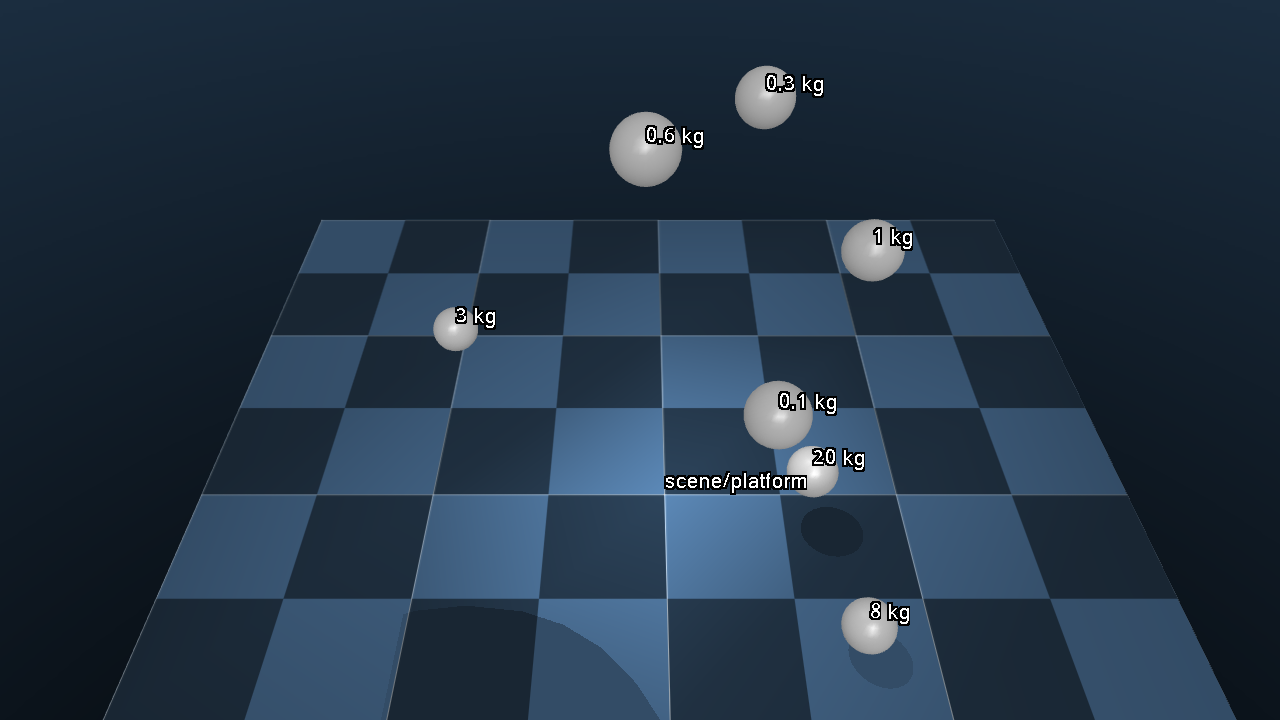

In [6]:
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.label = enums.mjtLabel.mjLABEL_GEOM  # enable body labels

mediapy.show_image(
    physics.render(height=height, width=width, scene_option=scene_option)
)

Save the rendered image

In [7]:
mediapy.write_image(f"../../media/{section}_{unit}_center_of_mass_not_shown.png", physics.render(height=height, width=width, scene_option=scene_option))

Now we enable `MuJoCo` to show the center of mass (COM). However, we will find that COM is shown as white spheres. There are 3 spheres since COM is shown for each body and for the entire world, which is nice. The problem is in the size or color of COM spheres, they may be near each other, which makes it a bit uncomfortable to look at them.

""

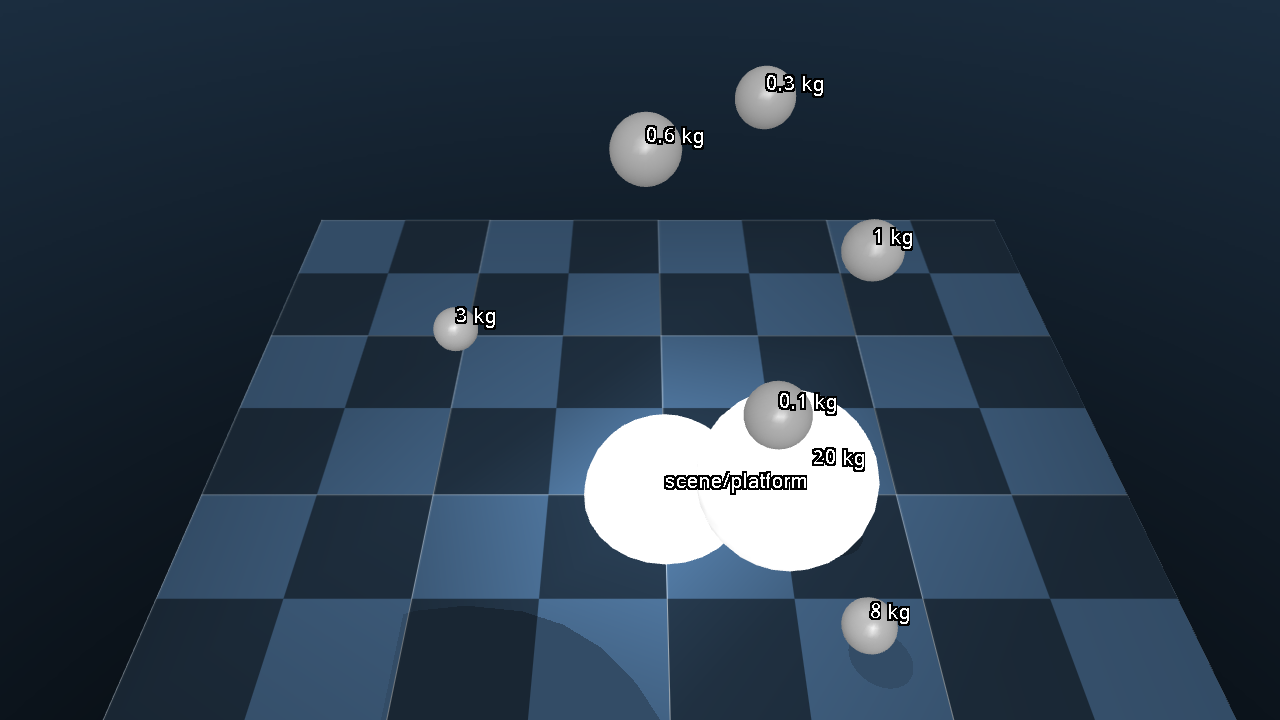

In [8]:
scene_option.flags[enums.mjtVisFlag.mjVIS_COM] = True
mediapy.show_image(physics.render(height=height, width=width, scene_option=scene_option))

We can add our own COM spheres. First of all, we must get the coordintaes of the COM.

In [9]:
physics.named.data.subtree_com

FieldIndexer(subtree_com):
                 x         y         z         
0        world [ 0.915    -0.408     0.757   ]
1       scene/ [ 0         0         0       ]
2 sphere_group [ 0.915    -0.408     0.757   ]

Now, let's take only the interesting coordinates.

In [10]:
physics.named.data.subtree_com["sphere_group"]

array([ 0.91547401, -0.40754026,  0.75740813])

Let's add a big red sphere at the location of these coordinates.

In [11]:
model.worldbody.add(
    "geom", name="center of mass", pos=physics.named.data.subtree_com["sphere_group"], size=[0.5], rgba=[1, 0, 0, 1]
)

MJCF Element: <geom name="center of mass" class="/" size="0.5" rgba="1 0 0 1" pos="0.91547401309494503 -0.40754025790364123 0.75740813000028517"/>

Update the physics since we updated the model.

In [12]:
physics = mjcf.Physics.from_mjcf_model(model)

Render the image again, and voilà!

""

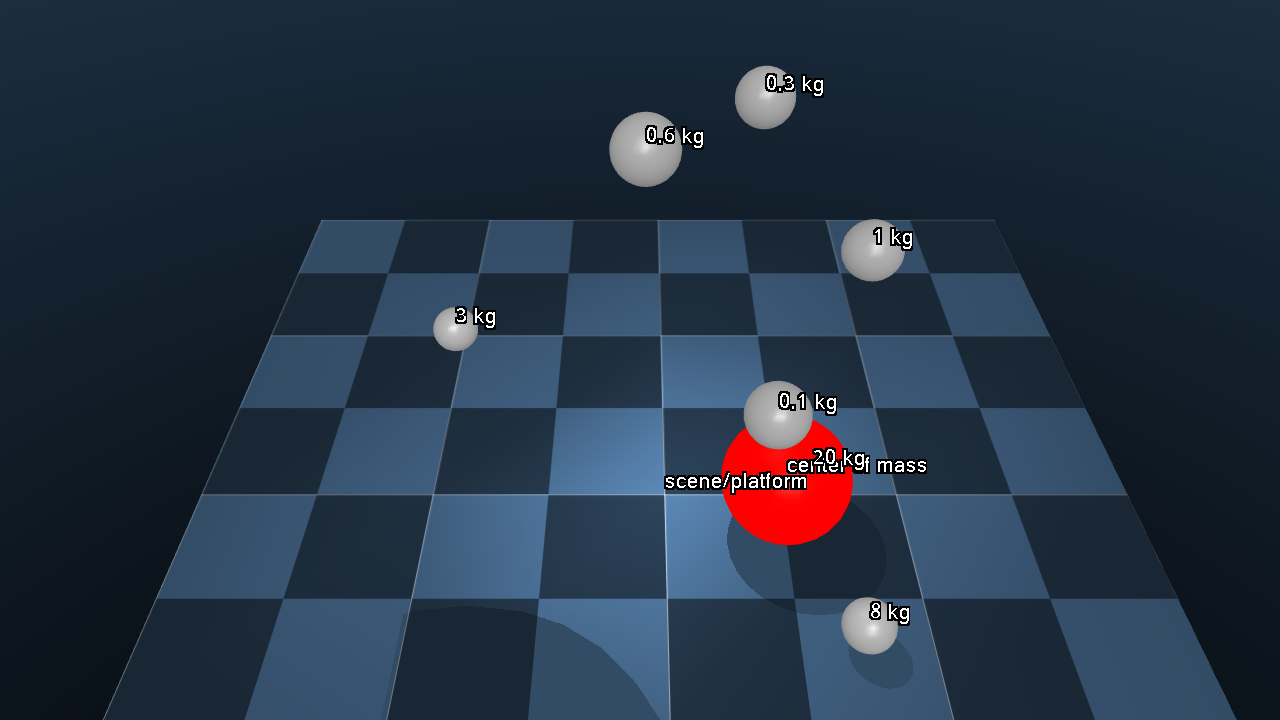

In [13]:
scene_option.flags[enums.mjtVisFlag.mjVIS_COM] = False
scene_option.flags[enums.mjtLabel.mjLABEL_GEOM] = True
mediapy.show_image(physics.render(height=height, width=width, scene_option=scene_option))

Saving the new rendered image

In [14]:
mediapy.write_image(f"../../media/{section}_{unit}_center_of_mass_shown.png", physics.render(height=height, width=width, scene_option=scene_option))